In [1]:
# ===============================
# Library Imports
# ===============================
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from tqdm import tqdm
import copy
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from functools import partial
import optuna
from typing import List, Optional, Tuple
from dataclasses import dataclass

In [2]:
# ===============================
# Global Settings for Reproducibility
# ===============================
# Choose device
device = "cpu"
torch.set_num_threads(os.cpu_count())

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

In [3]:
# =======================================
# Show the MNIST images from flattened vectors
# =======================================
MNIST_LABELS = [str(i) for i in range(10)]

def plot_mnist_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int] = (28, 28)
):
    """
    Plot MNIST images from flattened vectors

    Parameters
    ----------
    X : np.ndarray
        Flattened MNIST images (N, 784)
    y : np.ndarray
        True labels (N,) or one-hot (N, 10)
    y_pred : np.ndarray, optional
        Predicted labels (N,)
    num_images : int
        Number of images to display
    img_shape : Tuple[int, int]
        MNIST image shape (28, 28)

    Returns
    -------
    None

    Usage Example
    --------------
    plot_mnist_images(X_test, y_test, y_pred=y_pred, num_images=15)
    """
    # Convert labels to integer if needed
    if y.ndim > 1:
        y_true = np.argmax(y, axis=1)
    else:
        y_true = y

    num_images = min(num_images, len(X))

    n_cols = min(5, num_images)
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(3 * n_cols, 3 * n_rows))

    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)

        img = X[i].reshape(img_shape)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        title = f"True: {MNIST_LABELS[y_true[i]]}"
        if y_pred is not None:
            title += f"\nPred: {MNIST_LABELS[y_pred[i]]}"
            color = "green" if y_true[i] == y_pred[i] else "red"
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

Loading MNIST dataset...
Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Input dimension: 784, Output dimension: 10


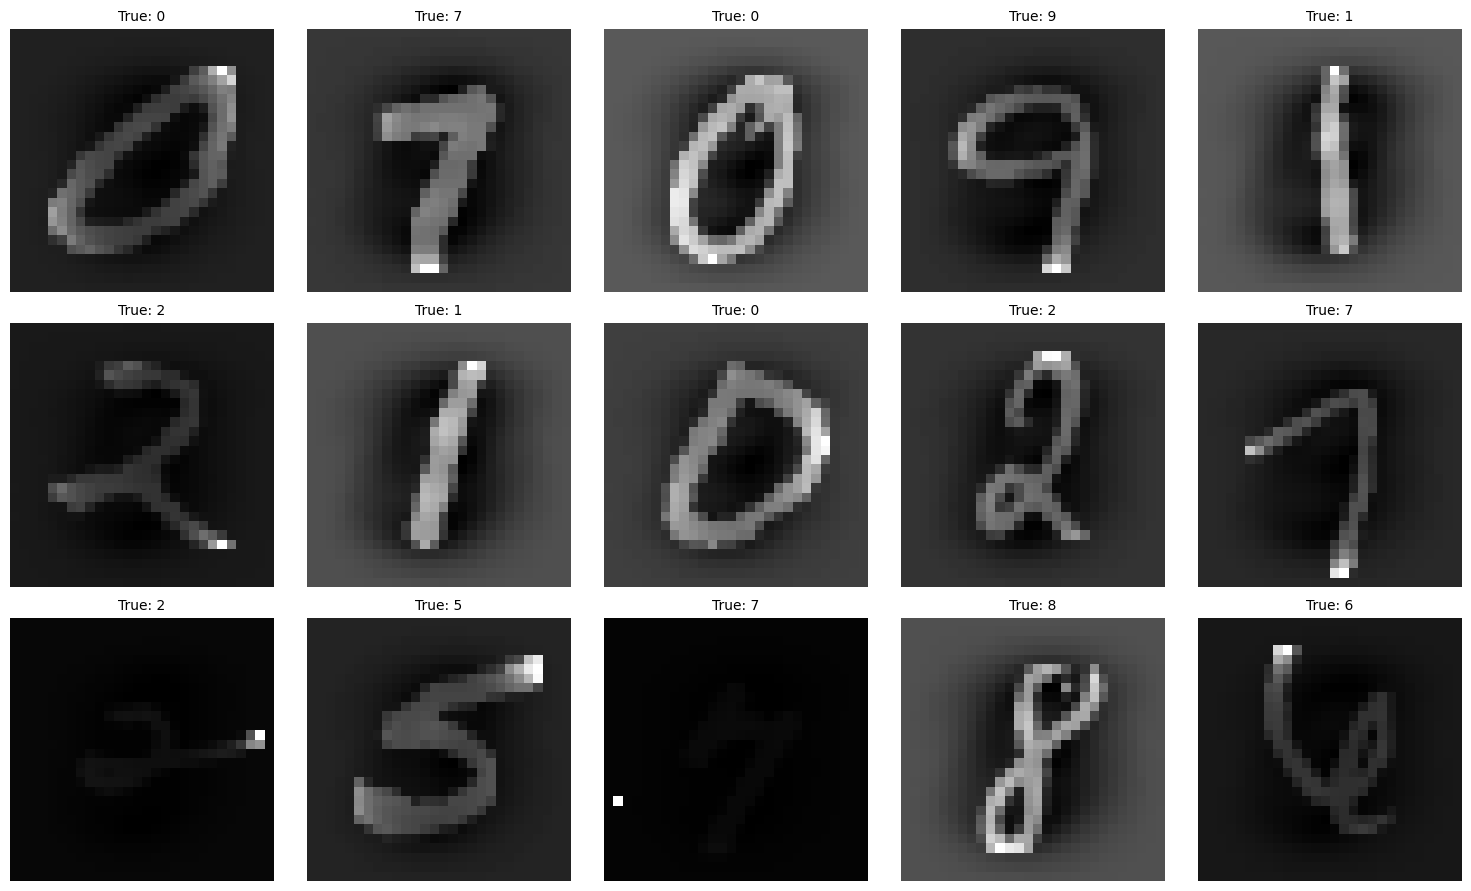

In [4]:
# =======================================
# Load and Preprocess Data of MNIST
# =======================================
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Usage:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED, stratify=y)
input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))
print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")

# Plot
plot_mnist_images(X=X_train, y=y_train, num_images=15)

In [5]:
# =======================================
# Tensor Creation
# =======================================
def df_to_tensor_dataset(
    X: np.ndarray,
    y: np.ndarray
) -> TensorDataset:
    """
    Convert numpy arrays to PyTorch TensorDataset

    Parameters
    ----------
    X : np.ndarray
        Feature data
    y : np.ndarray
        Labels

    Returns
    -------
    TensorDataset
        PyTorch TensorDataset containing features and labels

    Usage Example
    --------------
    dataset = df_to_tensor_dataset(X_train, y_train)
    """
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X_tensor, y_tensor)

def make_dataloaders(
    dataset: Dataset,
    batch_size: int,
    shuffle: bool = False
) -> DataLoader:
    """
    Create DataLoader from Dataset
    
    Parameters
    ----------
    dataset : Dataset
        PyTorch Dataset
    batch_size : int
        Batch size for DataLoader
    shuffle : bool
        Whether to shuffle the data

    Returns
    -------
    DataLoader
        PyTorch DataLoader

    Usage Example
    --------------
    dataloader = make_dataloaders(dataset, batch_size=32, shuffle=True)
    """
    return DataLoader(dataset, 
                      batch_size=batch_size, 
                      shuffle=shuffle, 
                      num_workers=os.cpu_count(), 
                      persistent_workers=True if os.cpu_count() > 1 else False
                    )

In [6]:
# =======================================
# Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "leaky_relu": lambda: nn.LeakyReLU(negative_slope=0.01),
    "gelu": nn.GELU,
    "elu": nn.ELU,
    "softmax_logit": None  # handled as logits for CrossEntropy
}

In [7]:
# =======================================
# Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    step_size: int = 20
    gamma: float = 0.5

In [8]:
# =======================================
# Model Definition
# =======================================
class DeepNN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True
    ):
        super().__init__()
        layers = []
        prev = input_dim
        n_hidden = len(hidden_layers)

        if activations is None:
            activations = ["relu"] * n_hidden
        if dropout_rates is None:
            dropout_rates = [0.0] * n_hidden
        assert len(activations) == n_hidden
        assert len(dropout_rates) == n_hidden

        for idx, h in enumerate(hidden_layers):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            if act_ctor is None and act_name != "softmax_logit":
                raise ValueError(f"Unsupported activation: {act_name}")
            if act_ctor is not None:
                layers.append(act_ctor())
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                layers.append(nn.Dropout(dropout_rates[idx]))
            prev = h
        
        # Output layer (no activation here if using CrossEntropy)
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

        self._init_weights(activations)

    def _init_weights(self, activations: List[str]):
        idx_hidden = 0
        for m in self.net:
            if isinstance(m, nn.Linear):
                # choose activation of the incoming layer index
                act = activations[idx_hidden] if idx_hidden < len(activations) else None
                if act in ("relu", "leaky_relu"):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu") # He init
                else:
                    nn.init.xavier_normal_(m.weight) # Xavier init
                nn.init.zeros_(m.bias)
                idx_hidden += 1

    def forward(self, x):
        return self.net(x)

In [9]:
# =======================================
# EWC Implementation
# =======================================
class EWC:
    def __init__(self, model, dataloader, device, lambda_ewc=1000):
        self.model = model
        self.device = device
        self.lambda_ewc = lambda_ewc
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self.fisher = self._compute_fisher(dataloader)

    def _compute_fisher(self, dataloader):
        fisher = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}

        self.model.eval()
        criterion = nn.CrossEntropyLoss()

        for X, y in dataloader:
            X, y = X.to(self.device), y.to(self.device)
            self.model.zero_grad()
            output = self.model(X)
            loss = criterion(output, y)
            loss.backward()

            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.detach() ** 2

        for n in fisher:
            fisher[n] /= len(dataloader)

        return fisher

    def penalty(self, model):
        loss = 0.0
        for n, p in model.named_parameters():
            if n in self.fisher:
                loss += (self.fisher[n] * (p - self.params[n]) ** 2).sum()
        return self.lambda_ewc * loss

In [10]:
# =======================================
# Replay Buffer Implementation
# =======================================
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def add(self, dataset):
        for x, y in dataset:
            if len(self.memory) >= self.capacity:
                self.memory.pop(0)
            self.memory.append((x.cpu(), y.cpu()))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        batch = [self.memory[i] for i in indices]
        X, y = zip(*batch)
        return torch.stack(X), torch.tensor(y)

    def __len__(self):
        return len(self.memory)

In [11]:
# =======================================
# Training Loop
# =======================================
def train_model_on_task(
    model, 
    optimizer,
    train_dataset,
    batch_size: int = 64,
    step_size: int = 20,
    gamma: float = 0.5,
    loss_function: str = "cross_entropy",
    epochs: int = 10,
    replay_buffer: Optional[ReplayBuffer] = None, 
    replay_weight: Optional[float] = 1.0,
    ewc: Optional[EWC] = None,
    print_every: Optional[int] = 1
):  
    # Data preparation
    train_loader = make_dataloaders(train_dataset, batch_size, shuffle=True)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss() if loss_function == "cross_entropy" else nn.MSELoss()
    train_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Current task loss
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Replay loss
            if replay_buffer is not None and len(replay_buffer) >= batch_size:
                X_rep, y_rep = replay_buffer.sample(batch_size)
                X_rep, y_rep = X_rep.to(device), y_rep.to(device)
                logits_rep = model(X_rep)
                loss_rep = criterion(logits_rep, y_rep)
                loss += replay_weight * loss_rep

            # EWC penalty
            if ewc is not None:
                loss += ewc.penalty(model)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)

        scheduler.step()
        avg_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # Print progress
        if (epoch+1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_loss:.4f}")

    return model, train_losses

In [12]:
# =======================================
# Prediction & Evaluation
# =======================================
def predict_loader(model, loader, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    
    all_probs, all_preds, all_targets = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

    return (torch.cat(all_preds).numpy(), torch.cat(all_probs).numpy(), torch.cat(all_targets).numpy())

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def evaluate_task(model, dataset, device, batch_size=64):
    loader = make_dataloaders(dataset, batch_size=batch_size, shuffle=False)
    y_pred, _, y_true = predict_loader(model, loader, device)
    return accuracy_score(y_true, y_pred)

In [13]:
# =======================================
# Metrics to track performance
# =======================================
# Accuracy Matrix to track performance
class AccuracyMatrix:
    def __init__(self, num_tasks):
        self.num_tasks = num_tasks
        self.matrix = np.full((num_tasks, num_tasks), np.nan)

    def update(self, task_i, task_t, accuracy):
        """
        task_i: task evaluated
        task_t: task after which evaluation is done
        """
        self.matrix[task_i, task_t] = accuracy

    def get(self):
        return self.matrix

# Average Accuracy (AA): Measures average accuracy at the end of training
def average_accuracy(A):
    T = A.shape[0]
    return np.nanmean([A[i, T-1] for i in range(T)])

# Forgetting (F): Measures worst performance drop per task
def forgetting(A):
    T = A.shape[0]
    forgettings = []

    for i in range(T - 1):
        best_past = np.nanmax(A[i, :T-1])
        final = A[i, T-1]
        forgettings.append(best_past - final)

    return np.mean(forgettings)

# Forward Transfer (FT): Measures initial performance on new tasks 
# (Does learning previous tasks help before seeing the task?)
# requires baseline accuracy b_i
def forward_transfer(A, baseline):
    T = A.shape[0]
    fts = []

    for i in range(1, T):
        fts.append(A[i, i-1] - baseline[i])

    return np.mean(fts)

# Backward Transfer (BT): Measures influence of learning new tasks on previous tasks
def backward_transfer(A):
    T = A.shape[0]
    bts = []

    for i in range(T - 1):
        bts.append(A[i, T-1] - A[i, i])

    return np.mean(bts)

Task 0: Applied rotation drift


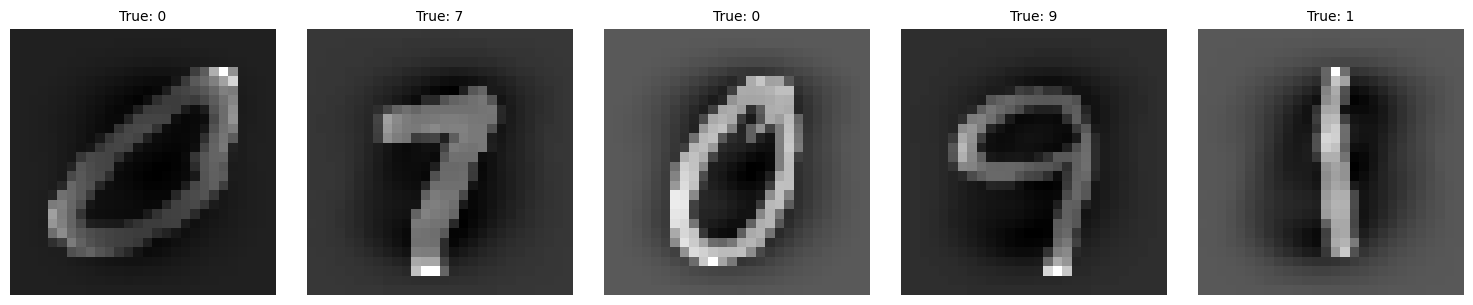

Task 1: Applied noise drift


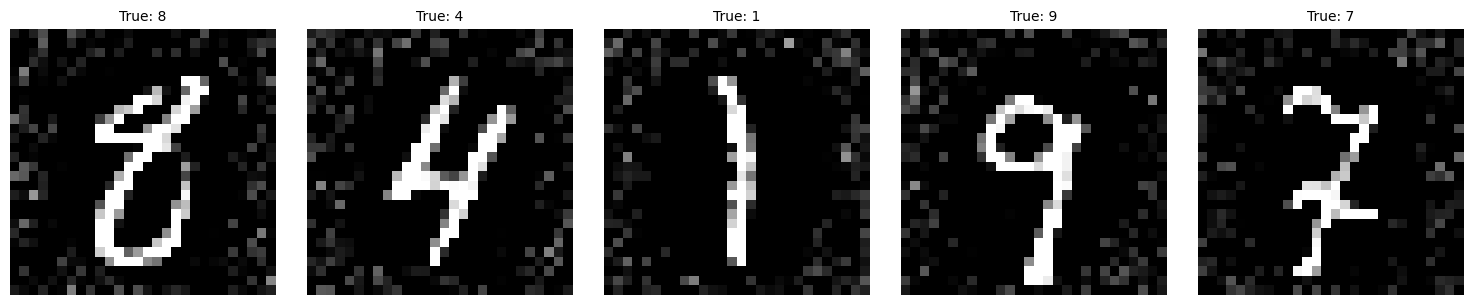

Task 2: Applied contrast drift


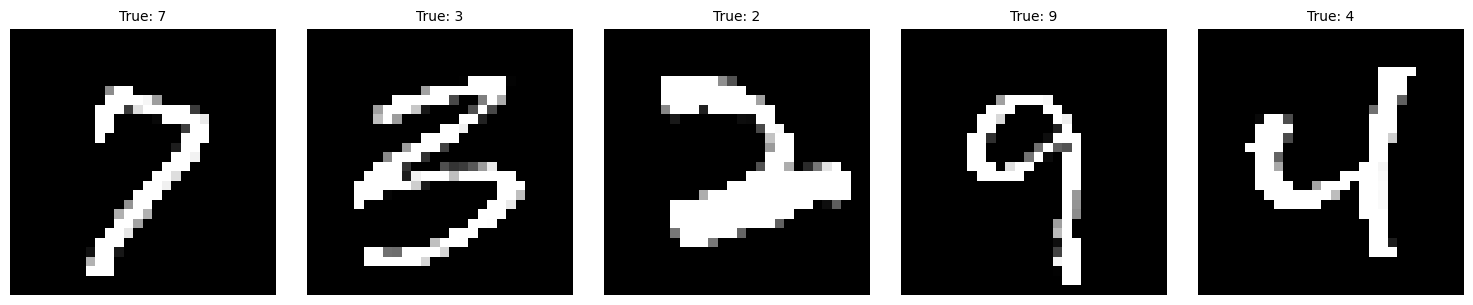

Task 3: Applied rotation drift


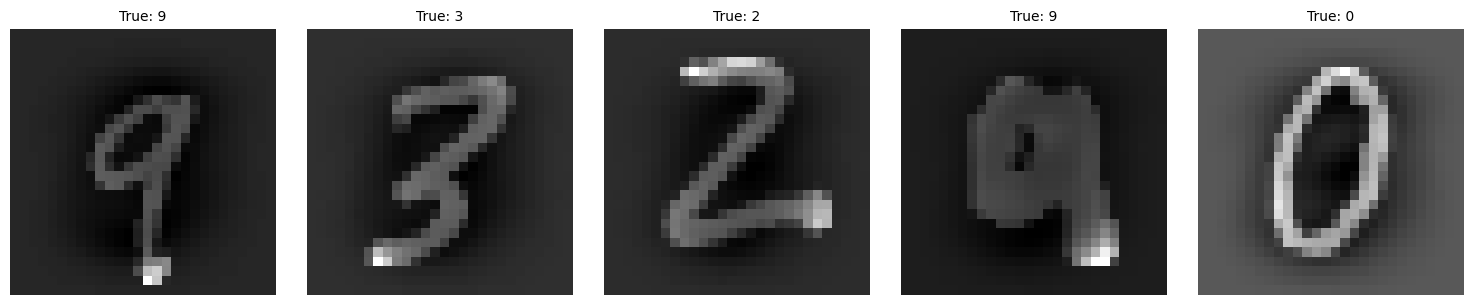

Task 4: Applied noise drift


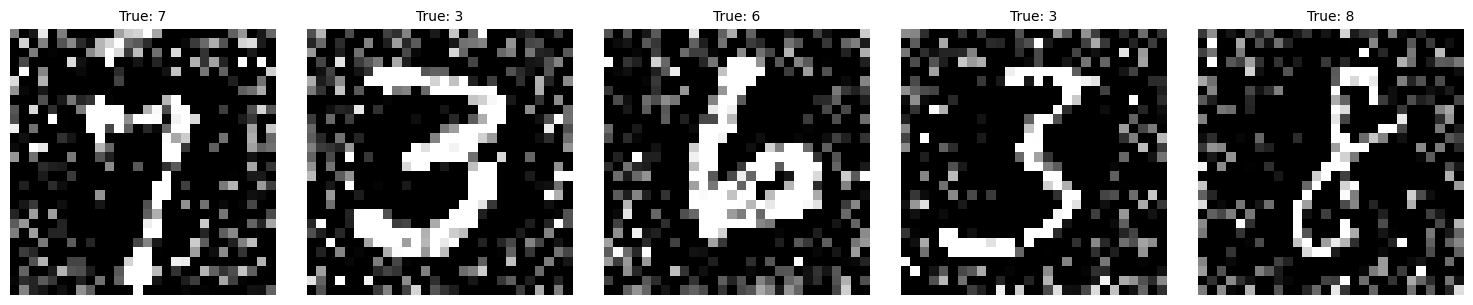

Created 5 Domain-IL tasks
 Task 0: 11200 samples, labels tensor([0, 7, 0, 9, 1, 2, 1, 0, 2, 7]) ...
 Task 1: 11200 samples, labels tensor([8, 4, 1, 9, 7, 7, 7, 9, 6, 7]) ...
 Task 2: 11200 samples, labels tensor([7, 3, 2, 9, 4, 2, 7, 4, 9, 0]) ...
 Task 3: 11200 samples, labels tensor([9, 3, 2, 9, 0, 7, 5, 3, 2, 9]) ...
 Task 4: 11200 samples, labels tensor([7, 3, 6, 3, 8, 4, 1, 9, 7, 3]) ...


In [14]:
# =======================================
# Create DOMAIN-IL tasks
# =======================================
"""
Definition:
- Task ID is NOT known at inference
- All tasks share the same output head
- The input distribution changes across tasks (e.g., rotations, noise)
- Forgetting can still occur if the model adapts too much to the new domain
"""
def make_domain_il_tasks(X, y, num_tasks=5):
    """
    Create Domain-IL tasks from MNIST with different drifts for each task.

    Parameters:
    - X, y: original MNIST data (N, 28*28)
    - num_tasks: number of incremental tasks

    Returns:
    - List of TensorDataset objects, one per domain/task
    """
    tasks = []
    X = X.reshape(-1, 28, 28)  # reshape to images

    # Define a list of possible drifts
    drift_types = ["rotation", "noise", "contrast"]

    for t in range(num_tasks):
        X_task = X.copy()
        # ony take len(X) / num_tasks data by task
        n_samples = len(X) // num_tasks
        X_task = X_task[t * n_samples:(t + 1) * n_samples]
        y_task = y[t * n_samples:(t + 1) * n_samples]

        # Randomly choose a drift type for this task
        drift = drift_types[t % len(drift_types)]  # cycle through types
        if drift == "rotation":
            angle = 15 * t  # e.g., 0, 15, 30, 45, ...
            X_task = np.array([np.rot90(img, k=angle // 90) for img in X_task])
        elif drift == "noise":
            noise_level = 0.1 * (t+1)
            X_task = X_task + noise_level * np.random.randn(*X_task.shape)
            X_task = np.clip(X_task, 0, 1)
        elif drift == "contrast":
            factor = 1 + 0.2 * t
            X_task = np.clip(X_task * factor, 0, 1)

        # Flatten back to (N, 28*28)
        X_task_flat = X_task.reshape(len(X_task), -1)
        print(f"Task {t}: Applied {drift} drift")
        plot_mnist_images(X=X_task_flat, y=y_task, num_images=5)
        task_dataset = df_to_tensor_dataset(X_task_flat, y_task)
        tasks.append(task_dataset)
    
    return tasks

# Example usage
num_tasks = 5
tasks = make_domain_il_tasks(X_train, y_train, num_tasks=num_tasks)
print(f"Created {len(tasks)} Domain-IL tasks")
for i, task in enumerate(tasks):
    print(f" Task {i}: {len(task)} samples, labels {task.tensors[1][:10]} ...")

In [15]:
# =======================================
# Initialize model and optimizer
# =======================================
# taking the previous best value in the Deep Neural Network project as reference
"""
Best trial:
  Value: 0.1003
  Params:
    n_layers: 3
    n_units_l0: 216
    n_units_l1: 251
    n_units_l2: 197
    lr: 0.0004980564413343545
    batch_size: 16
    dropout_l0: 0.4458944422648081
    dropout_l1: 0.186320146978403
    dropout_l2: 0.1279549248291706
    weight_decay: 8.560817132298919e-06
    optimizer: adam
    stopping_patience: 7
    activation_l0: leaky_relu
    activation_l1: tanh
    activation_l2: relu
    step_size: 14.161634448046335
    gamma: 0.4855325340941379
"""
hidden_layers = [216, 251, 197]
activations = ["leaky_relu", "tanh", "relu"]
dropout_rates = [0.4459, 0.1863, 0.1279]
model = DeepNN(input_dim, hidden_layers, output_dim, activations, dropout_rates)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0004980564413343545, weight_decay=8.560817132298919e-06)
batch_size = 16
epochs = 20
step_size = 14.161634448046335
gamma = 0.4855325340941379
print(model, optimizer)

DeepNN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=216, bias=True)
    (1): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.4459, inplace=False)
    (4): Linear(in_features=216, out_features=251, bias=True)
    (5): BatchNorm1d(251, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.1863, inplace=False)
    (8): Linear(in_features=251, out_features=197, bias=True)
    (9): BatchNorm1d(197, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1279, inplace=False)
    (12): Linear(in_features=197, out_features=10, bias=True)
  )
) AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0004980564413343545
    maximize: Fals

In [16]:
# =======================================
# Example Continual Learning Usage with EWC + Replay and Metrics Tracking
# =======================================
num_tasks = len(tasks)
acc_matrix = AccuracyMatrix(num_tasks)

replay_buffer = ReplayBuffer(capacity=2000)
ewc = None

for t, task_dataset in enumerate(tasks):
    print(f"\n=== Training on task {t} ===")

    # Train on current task with replay and EWC
    model, _ = train_model_on_task(
        model=model,
        optimizer=optimizer,
        train_dataset=task_dataset, 
        batch_size=batch_size, 
        epochs=epochs,
        step_size=step_size,
        gamma=gamma,
        replay_buffer=replay_buffer,
        replay_weight=1.0,
        ewc=ewc,
    )

    # Evaluate on all seen tasks (build accuracy matrix)
    for i in range(t + 1):
        acc = evaluate_task(model, tasks[i], device)
        acc_matrix.update(i, t, acc)

    # Update replay buffer after task
    replay_buffer.add(task_dataset)

    # Update EWC after task
    task_loader = DataLoader(task_dataset, batch_size=batch_size, shuffle=True)
    ewc = EWC(model, task_loader, device, lambda_ewc=500)


=== Training on task 0 ===
Epoch [1/20] | Train Loss: 0.8170
Epoch [2/20] | Train Loss: 0.4601
Epoch [3/20] | Train Loss: 0.3951
Epoch [4/20] | Train Loss: 0.3443
Epoch [5/20] | Train Loss: 0.3141
Epoch [6/20] | Train Loss: 0.2844
Epoch [7/20] | Train Loss: 0.2647
Epoch [8/20] | Train Loss: 0.2626
Epoch [9/20] | Train Loss: 0.2453
Epoch [10/20] | Train Loss: 0.2323
Epoch [11/20] | Train Loss: 0.2130
Epoch [12/20] | Train Loss: 0.2084
Epoch [13/20] | Train Loss: 0.1933
Epoch [14/20] | Train Loss: 0.1785
Epoch [15/20] | Train Loss: 0.1824
Epoch [16/20] | Train Loss: 0.1748
Epoch [17/20] | Train Loss: 0.1634
Epoch [18/20] | Train Loss: 0.1607
Epoch [19/20] | Train Loss: 0.1611
Epoch [20/20] | Train Loss: 0.1508

=== Training on task 1 ===
Epoch [1/20] | Train Loss: 0.4583
Epoch [2/20] | Train Loss: 0.3945
Epoch [3/20] | Train Loss: 0.3574
Epoch [4/20] | Train Loss: 0.3313
Epoch [5/20] | Train Loss: 0.3271
Epoch [6/20] | Train Loss: 0.3191
Epoch [7/20] | Train Loss: 0.3106
Epoch [8/20] | 

In [17]:
# =======================================
# Final Evaluation Metrics
# =======================================
A = acc_matrix.get()
print("Accuracy Matrix:\n", np.round(A, 2))
print("Average Accuracy:", average_accuracy(A))
print("Forgetting:", forgetting(A))
print("Backward Transfer:", backward_transfer(A))
print("Forward Transfer: N/A (requires baseline)")

Accuracy Matrix:
 [[0.99 0.98 0.93 0.97 0.97]
 [ nan 0.54 1.   0.68 0.45]
 [ nan  nan 0.98 0.69 0.47]
 [ nan  nan  nan 0.98 0.98]
 [ nan  nan  nan  nan 0.42]]
Average Accuracy: 0.6568035714285714
Forgetting: 0.2707142857142857
Backward Transfer: -0.15604910714285716
Forward Transfer: N/A (requires baseline)


In [18]:
# =======================================
# Evaluate model on test set
# =======================================
test_dataset = df_to_tensor_dataset(X_test, y_test)
test_loader = make_dataloaders(test_dataset, batch_size=64, shuffle=False)
y_pred, y_probs, y_true = predict_loader(model, test_loader, device)
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9581


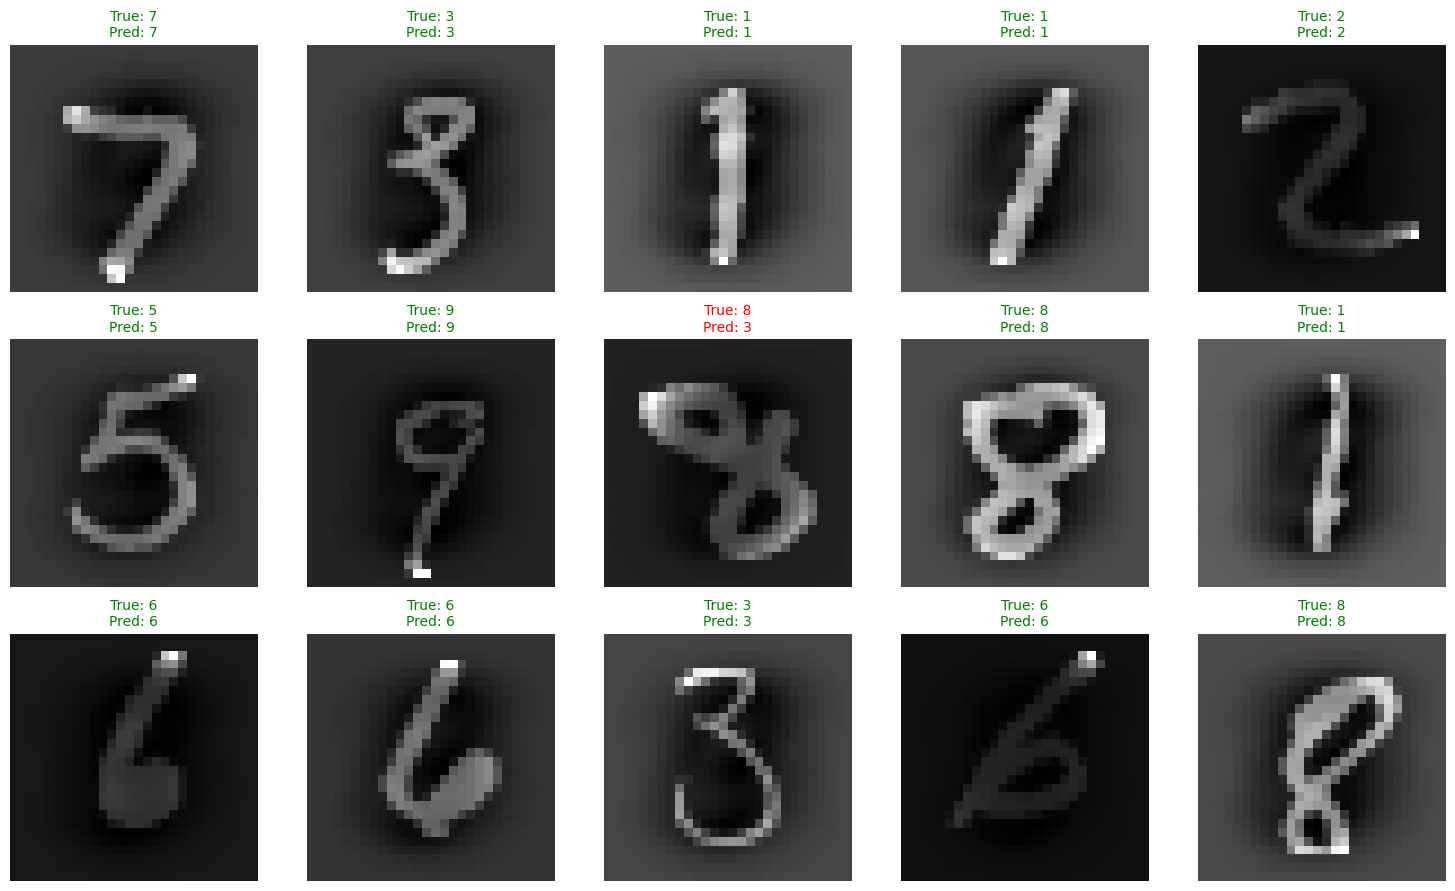

In [19]:
# =======================================
# Show some test images with predictions
# =======================================
plot_mnist_images(
    X=X_test,
    y=y_test,
    y_pred=y_pred,
    num_images=15
)